# ** March 22, 2022- Live Coding Session on CMIP6 Workflows **

## We'll start with downloading the data

In [1]:

import numpy as np
import xarray as xr
import xesmf as xe
import intake
import pickle
import dask
model_name_file = 'CanESM5'

import xclim
import xclim.sdba
import xclim.testing
import xarray as xr

# Visualizations and display
from pprint import pprint
from IPython.display import display
import matplotlib as mpl
import cftime
import matplotlib.pyplot as plt
import nc_time_axis
from dask.diagnostics import ProgressBar
# Some little figure tweaking
mpl.style.use('seaborn-deep')
mpl.style.use('seaborn-darkgrid')
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 5)

In [2]:
# for Google Cloud: Connect to CMIP6 data at Pangeo
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [3]:
#See what's available for CMIP6 on the Pangeo Cloud
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514968
dcpp_init_year,60


In [4]:
#Create query to get different tasmin, tasmax and pr for model of interest
query = dict(experiment_id=['historical', 'ssp126','ssp245','ssp370', 'ssp585'],
             table_id='day',
             source_id=model_name_file,
             variable_id=['tasmax', 'tasmin', 'pr'],
             member_id = 'r1i1p1f1',
             grid_label='gn')

In [5]:
#Perform our search and subset the number of unique hits
col_subset = col.search(require_all_on=['source_id'], **query)
col_subset.df.groupby('source_id')[['experiment_id', 'variable_id', 'table_id']].nunique()

,experiment_id,variable_id,table_id
source_id,,,
CanESM5,5,3,1


In [6]:
#Download datasets and merge into a dictionary
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True,
                                                "decode_times": True,
                                                "use_cftime": True})
# list all merged datasets
[key for key in dsets.keys()]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['ScenarioMIP.CCCma.CanESM5.ssp245.day.gn',
 'ScenarioMIP.CCCma.CanESM5.ssp370.day.gn',
 'CMIP.CCCma.CanESM5.historical.day.gn',
 'ScenarioMIP.CCCma.CanESM5.ssp126.day.gn',
 'ScenarioMIP.CCCma.CanESM5.ssp585.day.gn']

In [7]:
#let's look at the historical and SSP5-8.5 data
dshist=dsets[('CMIP.CCCma.'+ model_name_file+'.historical.day.gn')]
ds585=dsets[('ScenarioMIP.CCCma.'+ model_name_file+'.ssp585.day.gn')]

In [8]:
#Check and see what is in the dataset
ds585

<xarray.Dataset>
Dimensions:    (lat: 64, bnds: 2, lon: 128, member_id: 1, time: 60590)
Coordinates:
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
  * time       (time) object 2015-01-01 12:00:00 ... 2180-12-31 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(30295, 1), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    pr         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 1688, 64, 128), meta=np.ndarray>
    tasmax     (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 1885, 64, 128), meta=np.ndarray>
    tasmin     (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 1886, 64, 128), meta=np.ndarray>
Attributes: (12/58)
    source_id:                   CanESM5
    product:                     model-output
    license:                     CMIP6 model data produced by The Government ...
    contact:                     ec.cccma.info-info.ccmac.ec@canada.ca
    source:                      CanESM5 (2019): \naerosol: interactive\natmo...
    history:                     2019-05-02T08:56:23Z ;rewrote data to be con...
    ...                          ...
    parent_source_id:            CanESM5
    version:                     v20190429
    cmor_version:                3.4.0
    title:                       CanESM5 output prepared for CMIP6
    frequency:                   day
    intake_esm_dataset_key:      ScenarioMIP.CCCma.CanESM5.ssp585.day.gn

In [9]:
#what is the spatial resolution?
ds585["lat"].values, ds585["lon"].values

(array([-87.86379884, -85.09652699, -82.31291295, -79.52560657,
        -76.73689968, -73.94751515, -71.15775201, -68.36775611,
        -65.57760701, -62.7873518 , -59.99702011, -57.20663153,
        -54.41619953, -51.62573367, -48.83524097, -46.04472663,
        -43.25419467, -40.46364818, -37.67308963, -34.88252099,
        -32.09194388, -29.30135962, -26.51076933, -23.72017393,
        -20.92957425, -18.13897099, -15.34836476, -12.55775612,
         -9.76714556,  -6.97653355,  -4.18592053,  -1.39530691,
          1.39530691,   4.18592053,   6.97653355,   9.76714556,
         12.55775612,  15.34836476,  18.13897099,  20.92957425,
         23.72017393,  26.51076933,  29.30135962,  32.09194388,
         34.88252099,  37.67308963,  40.46364818,  43.25419467,
         46.04472663,  48.83524097,  51.62573367,  54.41619953,
         57.20663153,  59.99702011,  62.7873518 ,  65.57760701,
         68.36775611,  71.15775201,  73.94751515,  76.73689968,
         79.52560657,  82.31291295,  85.

## Let's Try Regridding the Data

In [10]:
#build regredder
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90, 90, 1.0)),
        "lon": (["lon"], np.arange(0, 360, 1)),
    }
)

regridder = xe.Regridder(ds585, ds_out, "bilinear")
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_64x128_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (64, 128) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False

In [11]:
#apply regridder to the datasets
ds585_out=regridder(ds585, keep_attrs=True)
ds585_out

<xarray.Dataset>
Dimensions:    (member_id: 1, time: 60590, lat: 180, lon: 360, bnds: 2)
Coordinates:
  * time       (time) object 2015-01-01 12:00:00 ... 2180-12-31 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(30295, 1), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
    height     float64 2.0
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat        (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 86.0 87.0 88.0 89.0
Dimensions without coordinates: bnds
Data variables:
    pr         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 1688, 180, 360), meta=np.ndarray>
    tasmax     (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 1885, 180, 360), meta=np.ndarray>
    tasmin     (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 1886, 180, 360), meta=np.ndarray>
Attributes: (12/59)
    source_id:                   CanESM5
    product:                     model-output
    license:                     CMIP6 model data produced by The Government ...
    contact:                     ec.cccma.info-info.ccmac.ec@canada.ca
    source:                      CanESM5 (2019): \naerosol: interactive\natmo...
    history:                     2019-05-02T08:56:23Z ;rewrote data to be con...
    ...                          ...
    version:                     v20190429
    cmor_version:                3.4.0
    title:                       CanESM5 output prepared for CMIP6
    frequency:                   day
    intake_esm_dataset_key:      ScenarioMIP.CCCma.CanESM5.ssp585.day.gn
    regrid_method:               bilinear

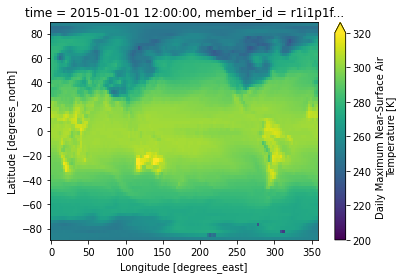

In [12]:
#let's plot slice in time of the raw data
ds585["tasmax"].isel(time=0).plot(vmin=200, vmax=320)

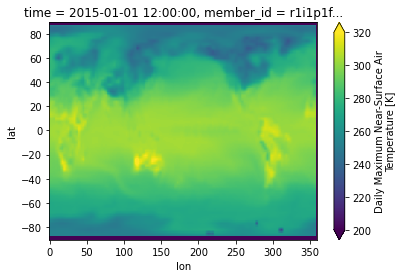

In [13]:
#and compare it to a plot of the regridded data
ds585_out["tasmax"].isel(time=0).plot(vmin=200, vmax=320)

## Amazing we're pros!  Let's re-use our regridder to also regrid our historical data from the model and use it for some bias correction

In [14]:
#Lets re-grid our historical data for CanESM5, we can use the gridder we made
dshist_out=regridder(dshist, keep_attrs=True)

In [5]:
#Lets load some historical observed data (we will call this reference) and CMIP CanESM5 data for RCP5.85 (both historical and future)
#We will convert all this data to Kelvin, specify our location and slice the ref/historical data for 1980-2010
dsref = xclim.testing.open_dataset('sdba/ahccd_1950-2013.nc')
dssim = xclim.testing.open_dataset('sdba/CanESM2_1950-2100.nc')
ref = xclim.core.units.convert_units_to(
    dsref.tasmax.sel(time=slice('1980', '2010'), location='Vancouver'),
    'K'
)
hist = xclim.core.units.convert_units_to(
    dssim.tasmax.sel(time=slice('1980', '2010'), location='Vancouver'),
    'K'
)
sim = xclim.core.units.convert_units_to(
    dssim.tasmax.sel(location='Vancouver'),
    'K'
)

In [6]:
#We will group our data in a 31 day window and apply Emprical Quantile Mapping
group_doy_31 = xclim.sdba.Grouper('time.dayofyear', window=31)

QM = xclim.sdba.EmpiricalQuantileMapping.train(
    ref, hist, nquantiles=15, group="time", kind="+"
)
scen = QM.adjust(sim, extrapolation="constant", interp="nearest")

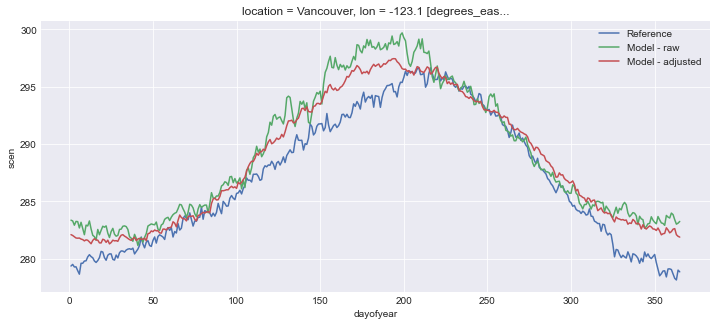

In [7]:
# Lets plot it to see the season cycle, and how we've adjusted the data
fig, ax = plt.subplots()
ref.groupby('time.dayofyear').mean().plot(ax=ax, label='Reference')
hist.groupby('time.dayofyear').mean().plot(ax=ax, label='Model - raw')
scen.groupby('time.dayofyear').mean().plot(ax=ax, label='Model - adjusted')
ax.legend();

In [8]:
#We can see what the quantile mapping spit out
QM.ds

<xarray.Dataset>
Dimensions:    (quantiles: 15, group: 1)
Coordinates:
  * quantiles  (quantiles) float32 0.03333 0.1 0.1667 ... 0.8333 0.9 0.9667
  * group      (group) int64 1
    lat        float64 49.1
    location   <U9 'Vancouver'
    lon        float64 -123.1
Data variables:
    af         (group, quantiles) float32 -2.335 -1.95 -1.786 ... -3.74 -5.531
    hist_q     (group, quantiles) float32 278.9 281.3 282.6 ... 299.3 303.5
Attributes:
    group:               time
    group_compute_dims:  ['time']
    group_window:        1
    _xclim_adjustment:   {"py/object": "xclim.sdba.adjustment.EmpiricalQuanti...
    adj_params:          EmpiricalQuantileMapping(group=Grouper(add_dims=[], ...

In [ ]:
#We'll perform some calculations on our data and plot the means
with xclim.set_options(cf_compliance='log'):
    ref_tg = xclim.indicators.atmos.tx_mean(tasmax=ref)
    sim_tg = xclim.indicators.atmos.tx_mean(tasmax=sim)
    scen_tg = xclim.indicators.atmos.tx_mean(tasmax=scen)
    
ref_tgC = xclim.units.convert_units_to(ref_tg, "degC")
sim_tgC = xclim.units.convert_units_to(sim_tg, "degC")
scen_tgC = xclim.units.convert_units_to(scen_tg, "degC")


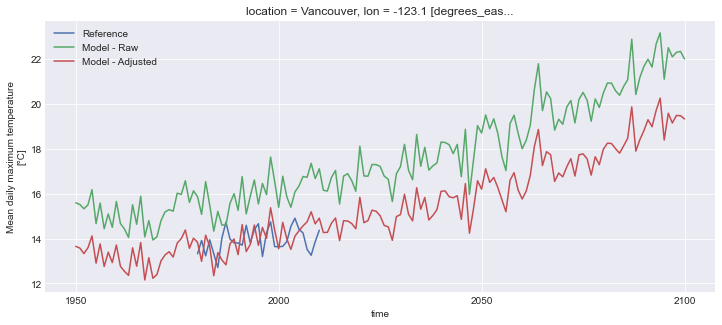

In [15]:
fig, ax = plt.subplots()
ref_tgC.plot(ax=ax, label='Reference')
sim_tgC.plot(ax=ax, label='Model - Raw')
scen_tgC.plot(ax=ax, label='Model - Adjusted')
ax.legend();

In [ ]:
## Looks it might be warm!  Better get the AC unit (or maybe make some system shifts)!